# Bibliotecas

Vamos usar a biblioteca de alto nível [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/) que contém a implementação do Deep Q-learning (DQN), dentre outros algoritmos de aprendizado por reforço.

In [1]:
# Instala os pacotes necessários:
# - gymnasium[toy-text]: inclui ambientes simples como FrozenLake, Taxi, etc.
# - imageio[ffmpeg]: permite salvar vídeos e GIFs (formato .mp4 ou .gif)
# !pip install gymnasium[toy-text] imageio[ffmpeg] torchinfo
# !pip install stable-baselines3

In [6]:
# Importa as bibliotecas principais
import gymnasium as gym               # Biblioteca de simulações de ambientes para RL
import imageio                        # Usada para salvar a sequência de frames como GIF
from IPython.display import Image     # Para exibir a imagem (GIF) diretamente no notebook
import numpy as np                    # Importa o pacote NumPy, amplamente utilizado para manipulação de arrays e operações numéricas vetoriais
from typing import Dict, Tuple, List  # Importa ferramentas de tipagem estática do Python
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, ProgressBarCallback
from stable_baselines3.common.monitor import Monitor
from torchinfo import summary
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import torch
import pandas as pd
import seaborn as sns

2025-07-12 20:43:50.670813: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-12 20:43:50.678253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752363830.687408  221132 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752363830.690193  221132 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752363830.697508  221132 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Ambientes

In [7]:
ambientes = ["MountainCar-v0", "CartPole-v1", "Acrobot-v1"]
amb = ambientes[2]
train_env = Monitor(gym.make(amb, render_mode=None))
eval_env  = Monitor(gym.make(amb, render_mode=None))

# Callback

In [8]:
# Configura avaliação periódica
eval_cb = EvalCallback(
    eval_env,                 	  # ambiente só para avaliação
    eval_freq=1000,               # faz avaliação a cada 1 000 passos de treino
    n_eval_episodes=1,           # roda 10 episódios por avaliação
    log_path="./logs/" + amb,     # grava evaluations.npz nessa pasta
    deterministic=True,           # usa ações gulosas
    verbose=0                     # sem mensagens no console
)

# Hiperparâmetros

In [9]:
params = {
    "CartPole-v1": {
        "policy": "MlpPolicy",
        "learning_rate": 2.3e-3,
        "batch_size": 64,
        "buffer_size": 100_000,
        "learning_starts": 1_000,
        "gamma": 0.99,
        "target_update_interval": 10,
        "train_freq": 256,
        "gradient_steps": 128,
        "exploration_fraction": 0.16,
        "exploration_final_eps": 0.04,
        "policy_kwargs": {"net_arch": [256, 256]},
    },
    "MountainCar-v0": {
        "policy": "MlpPolicy",
        "learning_rate": 4e-3,
        "batch_size": 128,
        "buffer_size": 10_000,
        "learning_starts": 1_000,
        "gamma": 0.98,
        "target_update_interval": 600,
        "train_freq": 16,
        "gradient_steps": 8,
        "exploration_fraction": 0.20,
        "exploration_final_eps": 0.07,
        "policy_kwargs": {"net_arch": [256, 256]},
    },
    "Acrobot-v1": {
        "policy": "MlpPolicy",
        "learning_rate": 6.3e-4,
        "batch_size": 128,
        "buffer_size": 50_000,
        "learning_starts": 0,
        "gamma": 0.99,
        "target_update_interval": 250,
        "train_freq": 4,
        "gradient_steps": -1,
        "exploration_fraction": 0.12,
        "exploration_final_eps": 0.10,
        "policy_kwargs": {"net_arch": [256, 256]},
    },
}
n_timesteps = {
    "CartPole-v1": 5e4,
    "MountainCar-v0": 1.2e5,
    "Acrobot-v1":1e5
}

[**Hiperparâmetros**](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html#):

`learning_rate`: taxa de aprendizado

`batch_size`: tamanho do mini lote.

`buffer_size`: capacidade máxima do replay buffer; ao atingir o limite, amostras mais antigas são sobrescritas.

`learning_starts`: número de interações com o ambiente antes de iniciar o treinamento.

`gamma`: fator de desconto.

`train_freq`: frequência (em passos de ambiente) com que a rede é atualizada; a cada train_freq interações executa-se um ciclo de treino.

`gradient_steps`: número de passos de otimização consecutivos executados.

`target_update_interval`: número de passos entre as atualizações dos pesos da rede-alvo.

`exploration_fraction`: fração do total de passos de treino para decaimento de epsilon.

`exploration_final_eps`: valor final de epsilon após o decaimento.

`policy_kwargs = dict(net_arch=[256, 256])`: argumentos adicionais passados à política; aqui define-se uma MLP com duas camadas totalmente conectadas de 256 unidades cada.

# Modelo

In [7]:
params[amb].update({"env": train_env, "verbose": 0})
model = DQN(**params[amb])

In [8]:
summary(
    model.policy.q_net,
    input_size=(1,) + train_env.observation_space.shape,  # (batch_size, *observation_space.shape)
    col_names=["input_size", "output_size", "num_params"],
    depth=3
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
QNetwork                                 [1, 6]                    [1, 3]                    --
├─FlattenExtractor: 1-1                  [1, 6]                    [1, 6]                    --
│    └─Flatten: 2-1                      [1, 6]                    [1, 6]                    --
├─Sequential: 1-2                        [1, 6]                    [1, 3]                    --
│    └─Linear: 2-2                       [1, 6]                    [1, 256]                  1,792
│    └─ReLU: 2-3                         [1, 256]                  [1, 256]                  --
│    └─Linear: 2-4                       [1, 256]                  [1, 256]                  65,792
│    └─ReLU: 2-5                         [1, 256]                  [1, 256]                  --
│    └─Linear: 2-6                       [1, 256]                  [1, 3]                    771
Total params: 68,355
Traina

# Treinamento

In [9]:
model.learn(total_timesteps=n_timesteps[amb],
            callback=eval_cb,
            log_interval=None,
            progress_bar=True)
model.save("dqn")
model = DQN.load("dqn")

Output()

# Resultados

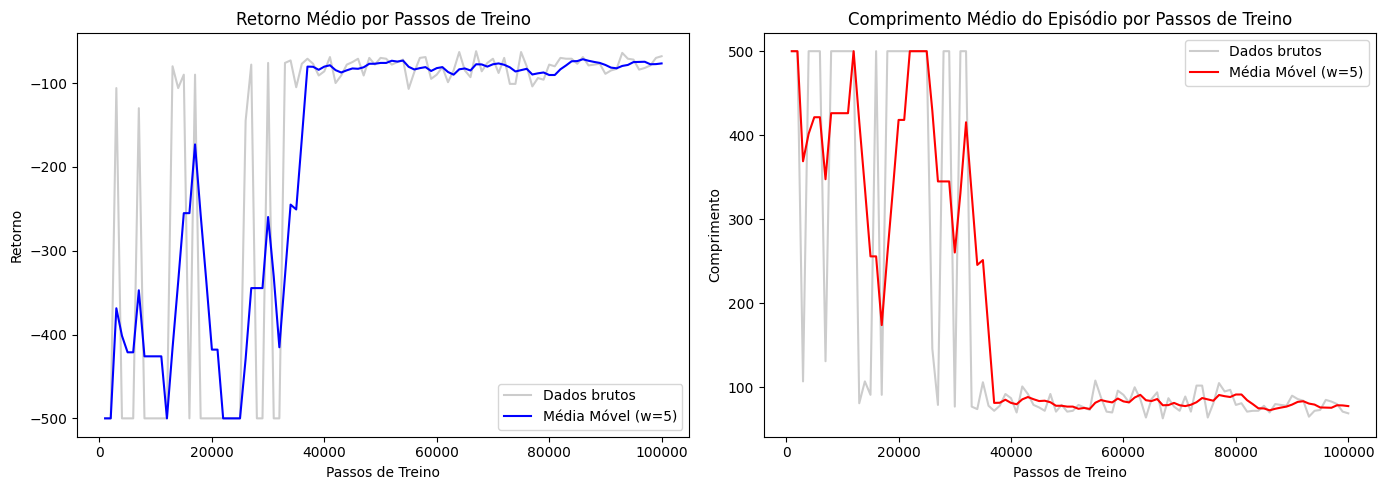

In [10]:
# 1. Carregar dados
data = np.load(f"logs/{amb}/evaluations.npz") # caminho passado para o EvalCallback
timesteps   = data["timesteps"]     # shape (n_evals,)
returns_raw = data["results"]      # shape (n_evals, n_eval_episodes)
lengths_raw = data["ep_lengths"]   # shape (n_evals, n_eval_episodes)

# 2. Calcular médias por ponto de avaliação
mean_ret = returns_raw.mean(axis=1)
mean_len = lengths_raw.mean(axis=1)

# 3. Criar DataFrame e média móvel (janela=5)
df = pd.DataFrame({
    "Passos de Treino": timesteps,
    "Retorno Médio": mean_ret,
    "Comprimento Médio": mean_len
})
df["Retorno MM"]     = df["Retorno Médio"].rolling(window=5, min_periods=1).mean()
df["Comprimento MM"] = df["Comprimento Médio"].rolling(window=5, min_periods=1).mean()

# 4. Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Retorno médio
sns.lineplot(
    x="Passos de Treino", y="Retorno Médio",
    data=df, ax=axes[0],
    label="Dados brutos",
    color="gray", alpha=0.4
)
sns.lineplot(
    x="Passos de Treino", y="Retorno MM",
    data=df, ax=axes[0],
    label="Média Móvel (w=5)",
    color="blue"
)
axes[0].set(
    title="Retorno Médio por Passos de Treino",
    xlabel="Passos de Treino",
    ylabel="Retorno"
)
axes[0].legend()

# Comprimento médio do episódio
sns.lineplot(
    x="Passos de Treino", y="Comprimento Médio",
    data=df, ax=axes[1],
    label="Dados brutos",
    color="gray", alpha=0.4
)
sns.lineplot(
    x="Passos de Treino", y="Comprimento MM",
    data=df, ax=axes[1],
    label="Média Móvel (w=5)",
    color="red"
)
axes[1].set(
    title="Comprimento Médio do Episódio por Passos de Treino",
    xlabel="Passos de Treino",
    ylabel="Comprimento"
)
axes[1].legend()

plt.tight_layout()
plt.show()

In [11]:
# Carrega o modelo e recria o ambiente
if amb == "MountainCar-v0":
  env    = gym.make(amb)

  model = DQN.load("dqn", env=env, print_system_info=False)

  # helper: SB3 policy → torch tensor → numpy Q-values
  def q_values(obs: np.ndarray) -> np.ndarray:
      with torch.no_grad():
          obs_t = torch.as_tensor(obs, dtype=torch.float32)
          q = model.policy.q_net(obs_t).cpu().numpy()
      return q

  # Constrói a grade de estados (posição, velocidade)
  pos_min, pos_max = env.observation_space.low[0],  env.observation_space.high[0]
  vel_min, vel_max = env.observation_space.low[1],  env.observation_space.high[1]

  N = 100                              # resolução da malha
  pos = np.linspace(pos_min, pos_max, N)
  vel = np.linspace(vel_min, vel_max, N)
  P, V = np.meshgrid(pos, vel)        # cada um (N,N)

  grid_states = np.stack([P.ravel(), V.ravel()], axis=1)   # (N², 2)

  # Avalia a rede (cost-to-go)
  qs          = q_values(grid_states)            # (N², 3 ações)
  values      = np.max(qs, axis=1)               # V(s) = max_a Q(s,a)
  cost_to_go  = - values.reshape(N, N)           # sinal trocado

  # Gráfico interativo
  surf = go.Surface(x=P, y=V, z=cost_to_go, colorscale="Viridis", showscale=False)
  fig_plotly = go.Figure(surf)
  fig_plotly.update_layout(
      title="Superfície cost-to-go (DQN) | Ambiente: " + amb,
      scene=dict(xaxis_title="Position",
                yaxis_title="Velocity",
                zaxis_title="Cost-to-go (–max Q)",
                aspectratio=dict(x=1, y=1, z=0.5)),
      margin=dict(l=0, r=0, b=0, t=30)
  )
  fig_plotly.show()

# Simulacão com a rede treinada

In [12]:
env = gym.make(amb, render_mode="rgb_array")
frames   = []
episodes = 1              # how many episodes to record
max_steps = 500           # MountainCar episode length
for ep in range(episodes):
    observation, info = env.reset()
    for step in range(max_steps):
        # agent acts
        action, _states = model.predict(observation, deterministic=True)
        observation, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            break
env.close()

/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [13]:
# Salva os frames coletados como um arquivo GIF animado
gif_path = amb + ".gif"
imageio.mimsave(gif_path, frames, format="GIF", duration=40)

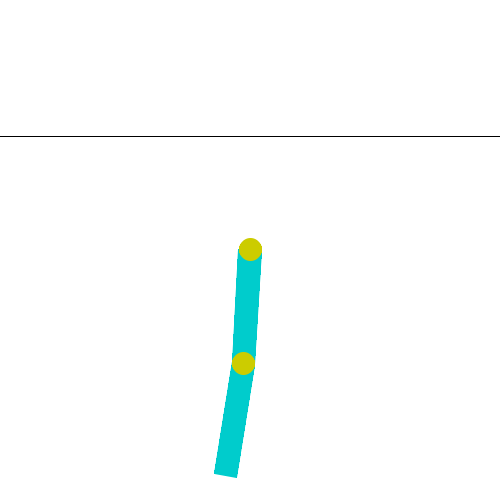

In [15]:
# Exibe o GIF diretamente no notebook
Image(filename=gif_path)

# Tarefa de Experimentos de Sensibilidade a Hiperparâmetros

Para cada um dos três ambientes, formule e execute 4 experimentos distintos em que apenas um hiperparâmetro é variado enquanto todos os outros são mantidos constatntes. Em seguida compare o desempenho (recompensa média e comprimento de episódio) entre as configurações testadas.

Cada um dos 4 experimentos deve:
- Manter todos os outros parâmetros fixos,
- Coletar métricas de recompensa média e comprimento/estabilidade do episódio
- Analisar gráficos comparativos e discorrer sobre como a alteração impactou o aprendizado.

### Funções utilitárias

In [15]:
def run_hyperparameter_experiment(ambiente, param_name, param_values, base_params, n_timesteps, eval_freq=1000):
    """
    Executa experimentos variando um hiperparâmetro específico.
    
    Args:
        ambiente: nome do ambiente (ex: "CartPole-v1")
        param_name: nome do parâmetro a ser variado
        param_values: lista de valores para testar
        base_params: parâmetros base do modelo
        n_timesteps: número de timesteps para treinamento
        eval_freq: frequência de avaliação
    
    Returns:
        results: dicionário com resultados para cada valor testado
    """
    results = {}
    
    for param_value in param_values:
        print(f"Testando {param_name} = {param_value}")
        
        # Cria ambiente de treino e avaliação
        train_env = Monitor(gym.make(ambiente, render_mode=None))
        eval_env = Monitor(gym.make(ambiente, render_mode=None))
        
        # Configura callback de avaliação
        log_path = f"./logs/{ambiente}_{param_name}_{param_value}"
        eval_cb = EvalCallback(
            eval_env,
            eval_freq=eval_freq,
            n_eval_episodes=5,
            log_path=log_path,
            deterministic=True,
            verbose=0
        )
        
        # Cria parâmetros do modelo com o valor específico
        model_params = base_params.copy()
        model_params[param_name] = param_value
        model_params["env"] = train_env
        model_params["verbose"] = 0
        
        # Treina o modelo
        model = DQN(**model_params)
        model.learn(total_timesteps=n_timesteps, callback=eval_cb, progress_bar=True)
        
        # Carrega resultados
        try:
            data = np.load(f"{log_path}/evaluations.npz")
            timesteps = data["timesteps"]
            returns_raw = data["results"]
            lengths_raw = data["ep_lengths"]
            
            results[param_value] = {
                "timesteps": timesteps,
                "mean_returns": returns_raw.mean(axis=1),
                "mean_lengths": lengths_raw.mean(axis=1),
                "final_return": returns_raw.mean(axis=1)[-1],
                "final_length": lengths_raw.mean(axis=1)[-1]
            }
        except FileNotFoundError:
            print(f"Arquivo de resultados não encontrado para {param_name}={param_value}")
            
        # Limpa memória
        del model, train_env, eval_env
        
    return results
def plot_hyperparameter_comparison(results_dict, param_name, ambiente, metric="returns"):
    """
    Cria gráfico comparativo para um hiperparâmetro específico.
    
    Args:
        results_dict: dicionário com resultados dos experimentos
        param_name: nome do parâmetro variado
        ambiente: nome do ambiente
        metric: "returns" ou "lengths"
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(results_dict)))
    
    for i, (param_value, data) in enumerate(results_dict.items()):
        if metric == "returns":
            y_data = data["mean_returns"]
            ylabel = "Retorno Médio"
            title_metric = "Recompensa Média"
        else:
            y_data = data["mean_lengths"]
            ylabel = "Comprimento Médio do Episódio"
            title_metric = "Comprimento do Episódio"
        
        # Aplicar média móvel para suavizar
        y_smooth = pd.Series(y_data).rolling(window=3, min_periods=1).mean()
        
        ax.plot(data["timesteps"], y_smooth, 
                label=f"{param_name}={param_value}", 
                color=colors[i], linewidth=2)
    
    ax.set_xlabel("Passos de Treino")
    ax.set_ylabel(ylabel)
    ax.set_title(f"Comparação {title_metric} - {param_name.replace('_', ' ').title()} - {ambiente}")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_all_hyperparameters_summary(all_results, ambiente):
    """
    Cria gráficos de resumo comparando todos os hiperparâmetros para um ambiente.
    
    Args:
        all_results: dicionário com resultados de todos os experimentos
        ambiente: nome do ambiente
    """
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    colors = ['blue', 'red', 'green', 'orange']
    param_names = ['learning_rate', 'batch_size', 'buffer_size', 'gamma']
    
    for idx, param_name in enumerate(param_names):
        if param_name in all_results:
            results = all_results[param_name]
            
            # Gráfico de retornos
            ax1 = axes[idx]
            for i, (param_value, data) in enumerate(results.items()):
                y_smooth = pd.Series(data["mean_returns"]).rolling(window=3, min_periods=1).mean()
                ax1.plot(data["timesteps"], y_smooth, 
                        label=f"{param_value}", alpha=0.8)
            
            ax1.set_title(f"Retorno - {param_name.replace('_', ' ').title()}")
            ax1.set_xlabel("Passos de Treino")
            ax1.set_ylabel("Retorno Médio")
            ax1.legend(fontsize=8)
            ax1.grid(True, alpha=0.3)
            
            # Gráfico de comprimentos
            ax2 = axes[idx + 4]
            for i, (param_value, data) in enumerate(results.items()):
                y_smooth = pd.Series(data["mean_lengths"]).rolling(window=3, min_periods=1).mean()
                ax2.plot(data["timesteps"], y_smooth, 
                        label=f"{param_value}", alpha=0.8)
            
            ax2.set_title(f"Comprimento - {param_name.replace('_', ' ').title()}")
            ax2.set_xlabel("Passos de Treino")
            ax2.set_ylabel("Comprimento Médio")
            ax2.legend(fontsize=8)
            ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f"Análise de Hiperparâmetros - {ambiente}", fontsize=16)
    plt.tight_layout()
    plt.show()


def create_performance_table(all_results, ambiente):
    """
    Cria tabela com desempenho final de cada configuração.
    
    Args:
        all_results: dicionário com resultados de todos os experimentos
        ambiente: nome do ambiente
    """
    data_rows = []
    
    for param_name, results in all_results.items():
        for param_value, data in results.items():
            data_rows.append({
                'Parâmetro': param_name.replace('_', ' ').title(),
                'Valor': param_value,
                'Retorno Final': f"{data['final_return']:.2f}",
                'Comprimento Final': f"{data['final_length']:.2f}"
            })
    
    df_performance = pd.DataFrame(data_rows)
    
    print(f"\n=== Tabela de Desempenho Final - {ambiente} ===")
    print(df_performance.to_string(index=False))
    
    return df_performance

## CartPole

Vamos avaliar a influência de diferentes valores de `learning_rate`, `batch_size`, `buffer_size` e `gamma` no desempenho do agente.

### Learning Rate

In [16]:
# Experimento Learning Rate - CartPole
print("=== Experimento Learning Rate - CartPole ===")

# Valores a serem testados
learning_rates = [1e-4, 1e-3, 2.3e-3, 5e-3, 1e-2]  # incluindo o valor base 2.3e-3

# Parâmetros base
base_params_cartpole = params["CartPole-v1"].copy()
ambiente = "CartPole-v1"

# Executar experimentos
lr_results_cartpole = run_hyperparameter_experiment(
    ambiente=ambiente,
    param_name="learning_rate", 
    param_values=learning_rates,
    base_params=base_params_cartpole,
    n_timesteps=int(n_timesteps[ambiente]),
    eval_freq=1000
)

print("Experimento Learning Rate - CartPole concluído!")

Output()

=== Experimento Learning Rate - CartPole ===
Testando learning_rate = 0.0001


Output()

Testando learning_rate = 0.001


Output()

Testando learning_rate = 0.0023


Output()

Testando learning_rate = 0.005


Output()

Testando learning_rate = 0.01


Experimento Learning Rate - CartPole concluído!


### Batch Size

In [17]:
# Experimento Batch Size - CartPole
print("=== Experimento Batch Size - CartPole ===")

# Valores a serem testados
batch_sizes = [16, 32, 64, 128, 256]  # incluindo o valor base 64

# Executar experimentos
bs_results_cartpole = run_hyperparameter_experiment(
    ambiente=ambiente,
    param_name="batch_size", 
    param_values=batch_sizes,
    base_params=base_params_cartpole,
    n_timesteps=int(n_timesteps[ambiente]),
    eval_freq=1000
)

print("Experimento Batch Size - CartPole concluído!")

Output()

=== Experimento Batch Size - CartPole ===
Testando batch_size = 16


Output()

Testando batch_size = 32


Output()

Testando batch_size = 64


Output()

Testando batch_size = 128


Output()

Testando batch_size = 256


Experimento Batch Size - CartPole concluído!


### Buffer Size

In [18]:
# Experimento Buffer Size - CartPole
print("=== Experimento Buffer Size - CartPole ===")

# Valores a serem testados
buffer_sizes = [10_000, 50_000, 100_000, 200_000, 500_000]  # incluindo o valor base 100_000

# Executar experimentos
buffer_results_cartpole = run_hyperparameter_experiment(
    ambiente=ambiente,
    param_name="buffer_size", 
    param_values=buffer_sizes,
    base_params=base_params_cartpole,
    n_timesteps=int(n_timesteps[ambiente]),
    eval_freq=1000
)

print("Experimento Buffer Size - CartPole concluído!")

Output()

=== Experimento Buffer Size - CartPole ===
Testando buffer_size = 10000


Output()

Testando buffer_size = 50000


Output()

Testando buffer_size = 100000


Output()

Testando buffer_size = 200000


Output()

Testando buffer_size = 500000


Experimento Buffer Size - CartPole concluído!


### Gamma

In [19]:
# Experimento Gamma - CartPole
print("=== Experimento Gamma - CartPole ===")

# Valores a serem testados
gammas = [0.95, 0.97, 0.99, 0.995, 0.999]  # incluindo o valor base 0.99

# Executar experimentos
gamma_results_cartpole = run_hyperparameter_experiment(
    ambiente=ambiente,
    param_name="gamma", 
    param_values=gammas,
    base_params=base_params_cartpole,
    n_timesteps=int(n_timesteps[ambiente]),
    eval_freq=1000
)

print("Experimento Gamma - CartPole concluído!")

Output()

=== Experimento Gamma - CartPole ===
Testando gamma = 0.95


Output()

Testando gamma = 0.97


Output()

Testando gamma = 0.99


Output()

Testando gamma = 0.995


Output()

Testando gamma = 0.999


Experimento Gamma - CartPole concluído!


## MountainCar

### Learning Rate

In [20]:
# Experimento Learning Rate - MountainCar
print("=== Experimento Learning Rate - MountainCar ===")

# Valores a serem testados
learning_rates_mc = [1e-4, 2e-3, 4e-3, 8e-3, 1e-2]  # incluindo o valor base 4e-3

# Parâmetros base
base_params_mountaincar = params["MountainCar-v0"].copy()
ambiente_mc = "MountainCar-v0"

# Executar experimentos
lr_results_mountaincar = run_hyperparameter_experiment(
    ambiente=ambiente_mc,
    param_name="learning_rate", 
    param_values=learning_rates_mc,
    base_params=base_params_mountaincar,
    n_timesteps=int(n_timesteps[ambiente_mc]),
    eval_freq=2000
)

print("Experimento Learning Rate - MountainCar concluído!")

Output()

=== Experimento Learning Rate - MountainCar ===
Testando learning_rate = 0.0001


Output()

Testando learning_rate = 0.002


Output()

Testando learning_rate = 0.004


Output()

Testando learning_rate = 0.008


Output()

Testando learning_rate = 0.01


Experimento Learning Rate - MountainCar concluído!


### Batch Size

In [21]:
# Experimento Batch Size - MountainCar
print("=== Experimento Batch Size - MountainCar ===")

# Valores a serem testados
batch_sizes_mc = [32, 64, 128, 256, 512]  # incluindo o valor base 128

# Executar experimentos
bs_results_mountaincar = run_hyperparameter_experiment(
    ambiente=ambiente_mc,
    param_name="batch_size", 
    param_values=batch_sizes_mc,
    base_params=base_params_mountaincar,
    n_timesteps=int(n_timesteps[ambiente_mc]),
    eval_freq=2000
)

print("Experimento Batch Size - MountainCar concluído!")

Output()

=== Experimento Batch Size - MountainCar ===
Testando batch_size = 32


Output()

Testando batch_size = 64


Output()

Testando batch_size = 128


Output()

Testando batch_size = 256


Output()

Testando batch_size = 512


Experimento Batch Size - MountainCar concluído!


### Buffer Size

In [22]:
# Experimento Buffer Size - MountainCar
print("=== Experimento Buffer Size - MountainCar ===")

# Valores a serem testados
buffer_sizes_mc = [5_000, 10_000, 20_000, 50_000, 100_000]  # incluindo o valor base 10_000

# Executar experimentos
buffer_results_mountaincar = run_hyperparameter_experiment(
    ambiente=ambiente_mc,
    param_name="buffer_size", 
    param_values=buffer_sizes_mc,
    base_params=base_params_mountaincar,
    n_timesteps=int(n_timesteps[ambiente_mc]),
    eval_freq=2000
)

print("Experimento Buffer Size - MountainCar concluído!")

Output()

=== Experimento Buffer Size - MountainCar ===
Testando buffer_size = 5000


Output()

Testando buffer_size = 10000


Output()

Testando buffer_size = 20000


Output()

Testando buffer_size = 50000


Output()

Testando buffer_size = 100000


Experimento Buffer Size - MountainCar concluído!


### Gamma

In [23]:
# Experimento Gamma - MountainCar
print("=== Experimento Gamma - MountainCar ===")

# Valores a serem testados
gammas_mc = [0.90, 0.95, 0.98, 0.99, 0.995]  # incluindo o valor base 0.98

# Executar experimentos
gamma_results_mountaincar = run_hyperparameter_experiment(
    ambiente=ambiente_mc,
    param_name="gamma", 
    param_values=gammas_mc,
    base_params=base_params_mountaincar,
    n_timesteps=int(n_timesteps[ambiente_mc]),
    eval_freq=2000
)

print("Experimento Gamma - MountainCar concluído!")

Output()

=== Experimento Gamma - MountainCar ===
Testando gamma = 0.9


Output()

Testando gamma = 0.95


Output()

Testando gamma = 0.98


Output()

Testando gamma = 0.99


Output()

Testando gamma = 0.995


Experimento Gamma - MountainCar concluído!


## AcrobotBot

### Learning Rate

In [24]:
# Experimento Learning Rate - Acrobot
print("=== Experimento Learning Rate - Acrobot ===")

# Valores a serem testados
learning_rates_ac = [3e-4, 6.3e-4, 1e-3, 2e-3, 5e-3]  # incluindo o valor base 6.3e-4

# Parâmetros base
base_params_acrobot = params["Acrobot-v1"].copy()
ambiente_ac = "Acrobot-v1"

# Executar experimentos
lr_results_acrobot = run_hyperparameter_experiment(
    ambiente=ambiente_ac,
    param_name="learning_rate", 
    param_values=learning_rates_ac,
    base_params=base_params_acrobot,
    n_timesteps=int(n_timesteps[ambiente_ac]),
    eval_freq=2000
)

print("Experimento Learning Rate - Acrobot concluído!")

Output()

=== Experimento Learning Rate - Acrobot ===
Testando learning_rate = 0.0003


Output()

Testando learning_rate = 0.00063


Output()

Testando learning_rate = 0.001


Output()

Testando learning_rate = 0.002


Output()

Testando learning_rate = 0.005


Experimento Learning Rate - Acrobot concluído!


### Batch Size

In [25]:
# Experimento Batch Size - Acrobot
print("=== Experimento Batch Size - Acrobot ===")

# Valores a serem testados
batch_sizes_ac = [32, 64, 128, 256, 512]  # incluindo o valor base 128

# Executar experimentos
bs_results_acrobot = run_hyperparameter_experiment(
    ambiente=ambiente_ac,
    param_name="batch_size", 
    param_values=batch_sizes_ac,
    base_params=base_params_acrobot,
    n_timesteps=int(n_timesteps[ambiente_ac]),
    eval_freq=2000
)

print("Experimento Batch Size - Acrobot concluído!")

Output()

=== Experimento Batch Size - Acrobot ===
Testando batch_size = 32


Output()

Testando batch_size = 64


Output()

Testando batch_size = 128


Output()

Testando batch_size = 256


Output()

Testando batch_size = 512


Experimento Batch Size - Acrobot concluído!


### Buffer Size

In [26]:
# Experimento Buffer Size - Acrobot
print("=== Experimento Buffer Size - Acrobot ===")

# Valores a serem testados
buffer_sizes_ac = [20_000, 50_000, 100_000, 200_000, 500_000]  # incluindo o valor base 50_000

# Executar experimentos
buffer_results_acrobot = run_hyperparameter_experiment(
    ambiente=ambiente_ac,
    param_name="buffer_size", 
    param_values=buffer_sizes_ac,
    base_params=base_params_acrobot,
    n_timesteps=int(n_timesteps[ambiente_ac]),
    eval_freq=2000
)

print("Experimento Buffer Size - Acrobot concluído!")

Output()

=== Experimento Buffer Size - Acrobot ===
Testando buffer_size = 20000


Output()

Testando buffer_size = 50000


Output()

Testando buffer_size = 100000


Output()

Testando buffer_size = 200000


Output()

Testando buffer_size = 500000


Experimento Buffer Size - Acrobot concluído!


### Gamma

In [27]:
# Experimento Gamma - Acrobot
print("=== Experimento Gamma - Acrobot ===")

# Valores a serem testados
gammas_ac = [0.95, 0.97, 0.99, 0.995, 0.999]  # incluindo o valor base 0.99

# Executar experimentos
gamma_results_acrobot = run_hyperparameter_experiment(
    ambiente=ambiente_ac,
    param_name="gamma", 
    param_values=gammas_ac,
    base_params=base_params_acrobot,
    n_timesteps=int(n_timesteps[ambiente_ac]),
    eval_freq=2000
)

print("Experimento Gamma - Acrobot concluído!")

Output()

=== Experimento Gamma - Acrobot ===
Testando gamma = 0.95


Output()

Testando gamma = 0.97


Output()

Testando gamma = 0.99


Output()

Testando gamma = 0.995


Output()

Testando gamma = 0.999


Experimento Gamma - Acrobot concluído!


# Comparação de Resultados dos Experimentos

Nesse tópico vamos comparar os resultados dos experimentos realizados nos três ambientes, focando nas métricas de recompensa média e comprimento do episódio.

## Análise Comparativa dos Resultados

### CartPole-v1 - Comparação de Hiperparâmetros

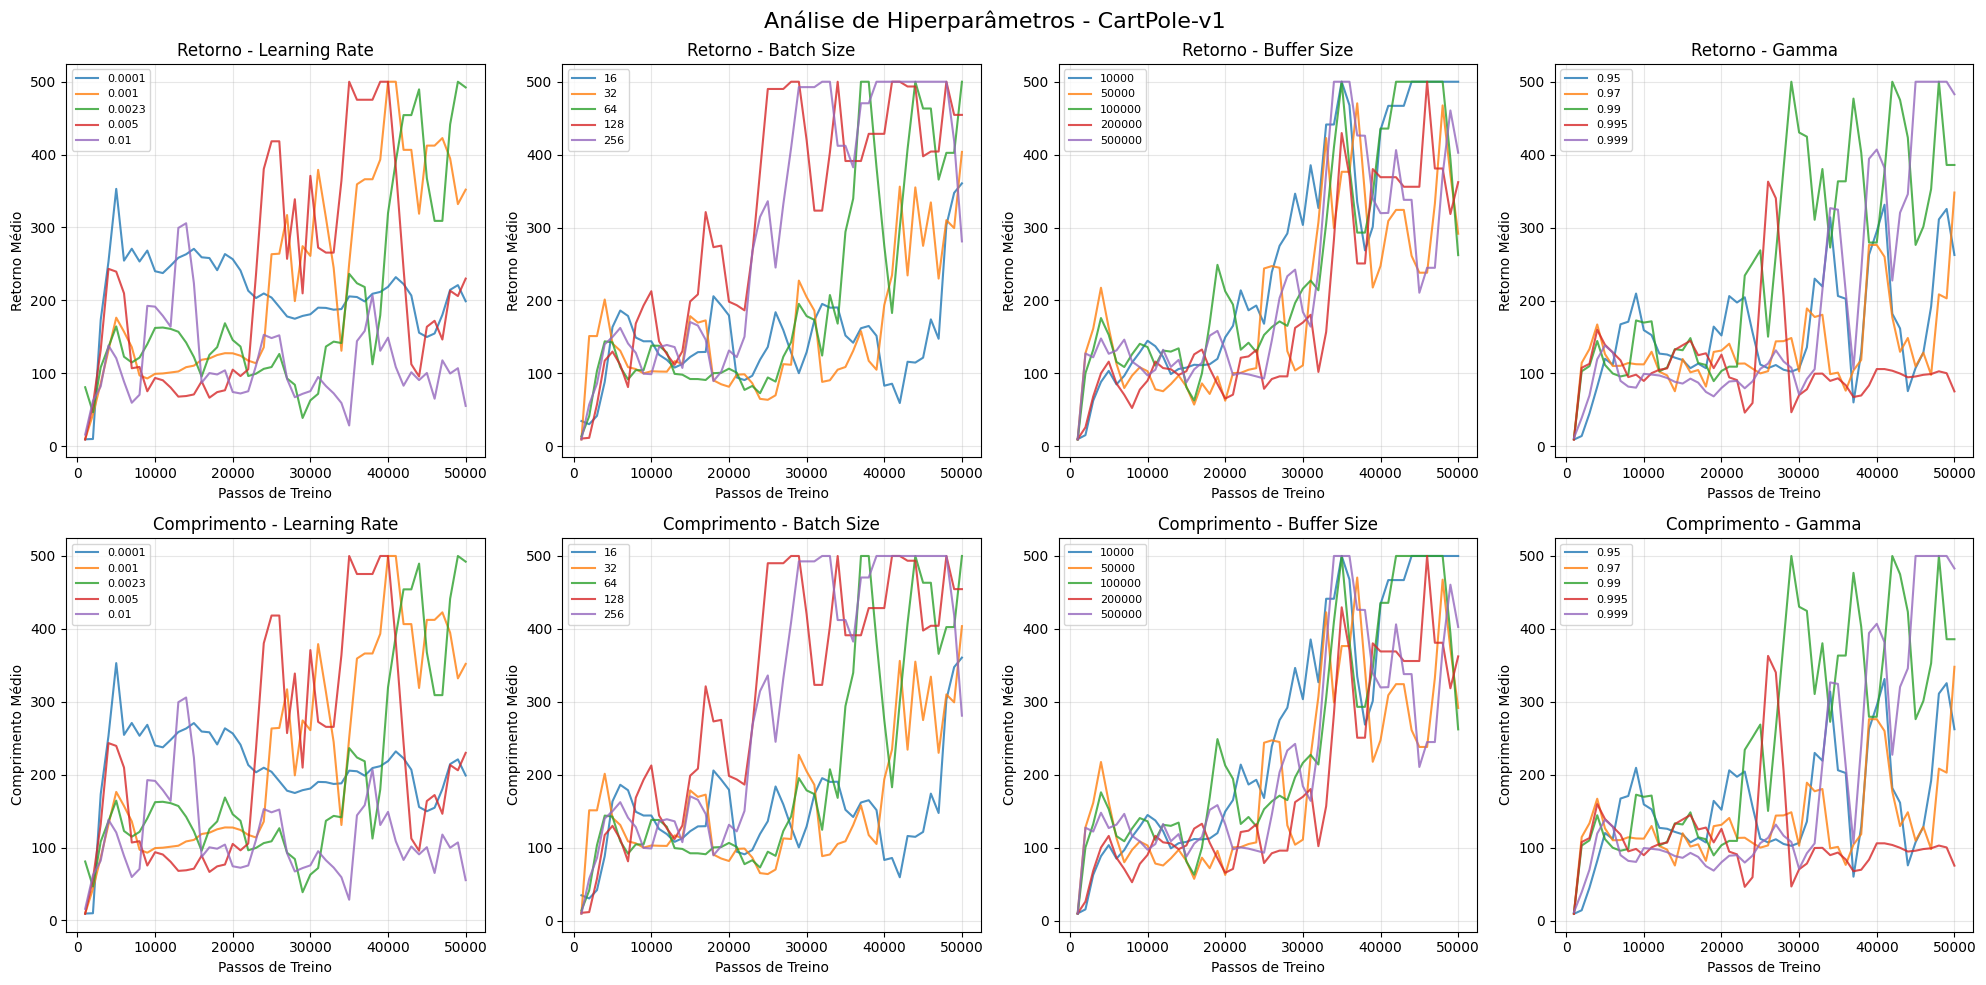


=== Tabela de Desempenho Final - CartPole-v1 ===
    Parâmetro       Valor Retorno Final Comprimento Final
Learning Rate      0.0001        162.60            162.60
Learning Rate      0.0010        327.60            327.60
Learning Rate      0.0023        476.60            476.60
Learning Rate      0.0050         90.80             90.80
Learning Rate      0.0100         18.00             18.00
   Batch Size     16.0000         81.80             81.80
   Batch Size     32.0000        500.00            500.00
   Batch Size     64.0000        500.00            500.00
   Batch Size    128.0000        500.00            500.00
   Batch Size    256.0000         86.80             86.80
  Buffer Size  10000.0000        500.00            500.00
  Buffer Size  50000.0000        160.00            160.00
  Buffer Size 100000.0000        104.40            104.40
  Buffer Size 200000.0000        274.20            274.20
  Buffer Size 500000.0000        326.20            326.20
        Gamma      0.9

In [28]:
# Organizar todos os resultados do CartPole
cartpole_results = {
    'learning_rate': lr_results_cartpole,
    'batch_size': bs_results_cartpole,
    'buffer_size': buffer_results_cartpole,
    'gamma': gamma_results_cartpole
}

# Gráfico resumo para CartPole
plot_all_hyperparameters_summary(cartpole_results, "CartPole-v1")

# Tabela de desempenho
cartpole_table = create_performance_table(cartpole_results, "CartPole-v1")

#### Conclusões gerais

**Learning Rate:**

- Taxas muito altas (0.01) tendem a oscilar mais e não convergir tão bem.
- Valores intermediários (0.001 ~ 0.0023) parecem obter melhores resultados em termos de estabilidade e desempenho final.

**Batch Size:**

- Batchs maiores (128, 256) tendem a melhorar mais rapidamente após ~20k passos.

- Pequenos batchs (16, 32) têm aprendizado mais lento e menos estável.

**Buffer Size:**
- Buffers maiores (100k ~ 500k) ajudam a estabilizar o aprendizado após ~30k passos.

- Buffers muito pequenos (10k) são menos estáveis.

**Gamma:**

- Valores maiores (0.99 ~ 0.999) tendem a favorecer um retorno maior, já que o agente prioriza recompensas futuras.

- Gammas menores (0.95) mostram pior desempenho.

### MountainCar-v0 - Comparação de Hiperparâmetros

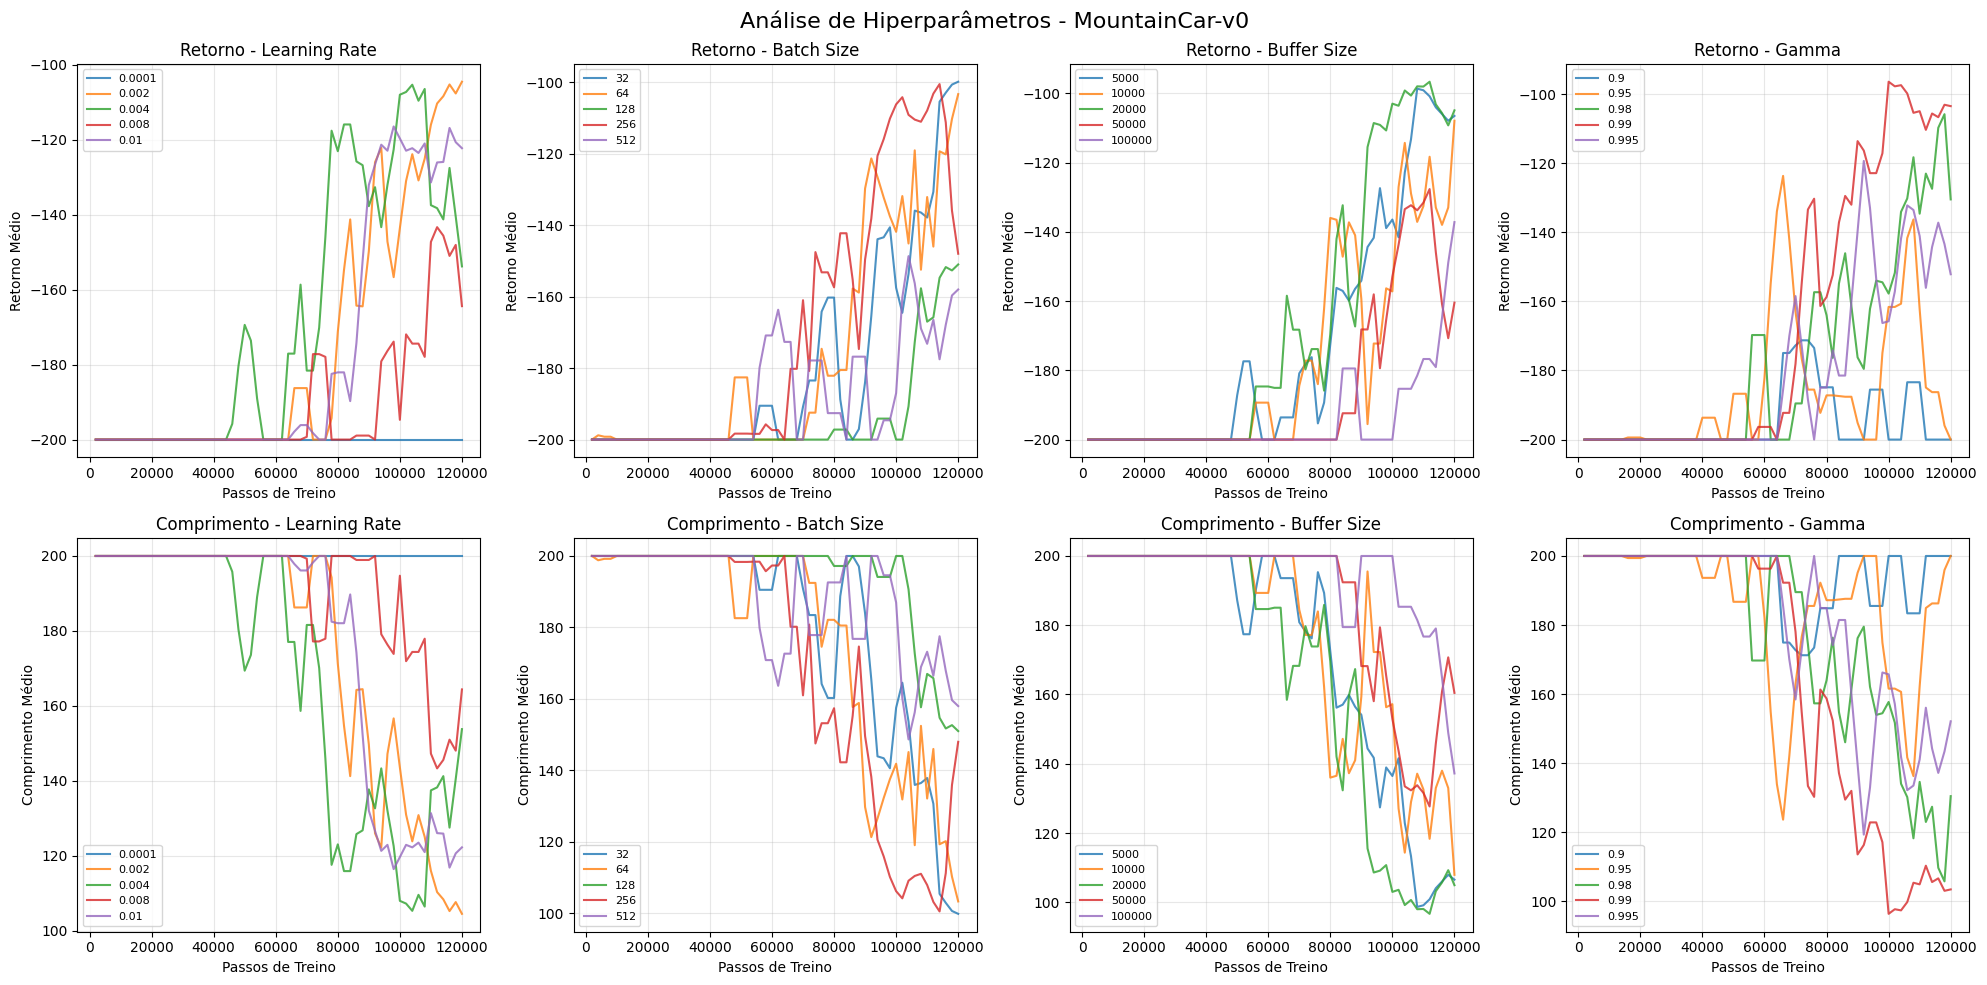


=== Tabela de Desempenho Final - MountainCar-v0 ===
    Parâmetro       Valor Retorno Final Comprimento Final
Learning Rate      0.0001       -200.00            200.00
Learning Rate      0.0020       -102.80            102.80
Learning Rate      0.0040       -151.20            151.20
Learning Rate      0.0080       -189.60            189.60
Learning Rate      0.0100       -121.20            121.20
   Batch Size     32.0000       -103.60            103.60
   Batch Size     64.0000        -99.20             99.20
   Batch Size    128.0000       -116.60            116.60
   Batch Size    256.0000       -134.80            134.80
   Batch Size    512.0000       -169.60            169.60
  Buffer Size   5000.0000       -103.40            103.40
  Buffer Size  10000.0000       -103.00            103.00
  Buffer Size  20000.0000       -102.40            102.40
  Buffer Size  50000.0000       -169.20            169.20
  Buffer Size 100000.0000       -116.40            116.40
        Gamma      

In [29]:
# Organizar todos os resultados do MountainCar
mountaincar_results = {
    'learning_rate': lr_results_mountaincar,
    'batch_size': bs_results_mountaincar,
    'buffer_size': buffer_results_mountaincar,
    'gamma': gamma_results_mountaincar
}

# Gráfico resumo para MountainCar
plot_all_hyperparameters_summary(mountaincar_results, "MountainCar-v0")

# Tabela de desempenho
mountaincar_table = create_performance_table(mountaincar_results, "MountainCar-v0")

#### Conclusões

**Learning Rate**

- Aprendizados começam devagar, mas com taxas 0.002 ~ 0.004 alcançam melhores retornos e episódios mais curtos depois de ~80k passos.
- Taxas muito baixas (0.0001) praticamente não aprendem. Taxas muito altas (0.01) oscilaram.

**Batch Size**

- Tamanhos médios (64, 128) tiveram melhor performance (retorno em torno de -110 e comprimento ~110 após 120k passos).
- Tamanho muito grande (512) não convergiu tão bem.

**Buffer Size**

- Buffers maiores (50k, 100k) permitiram um aprendizado mais estável e eficiente.
- Buffers muito pequenos (5k) dificultaram a melhora do retorno.

**Gamma**

- Valores altos (0.99, 0.995) resultaram nos melhores retornos e episódios mais curtos.
- Valores baixos (0.9) ficaram presos em desempenhos piores.

### Acrobot-v1 - Comparação de Hiperparâmetros

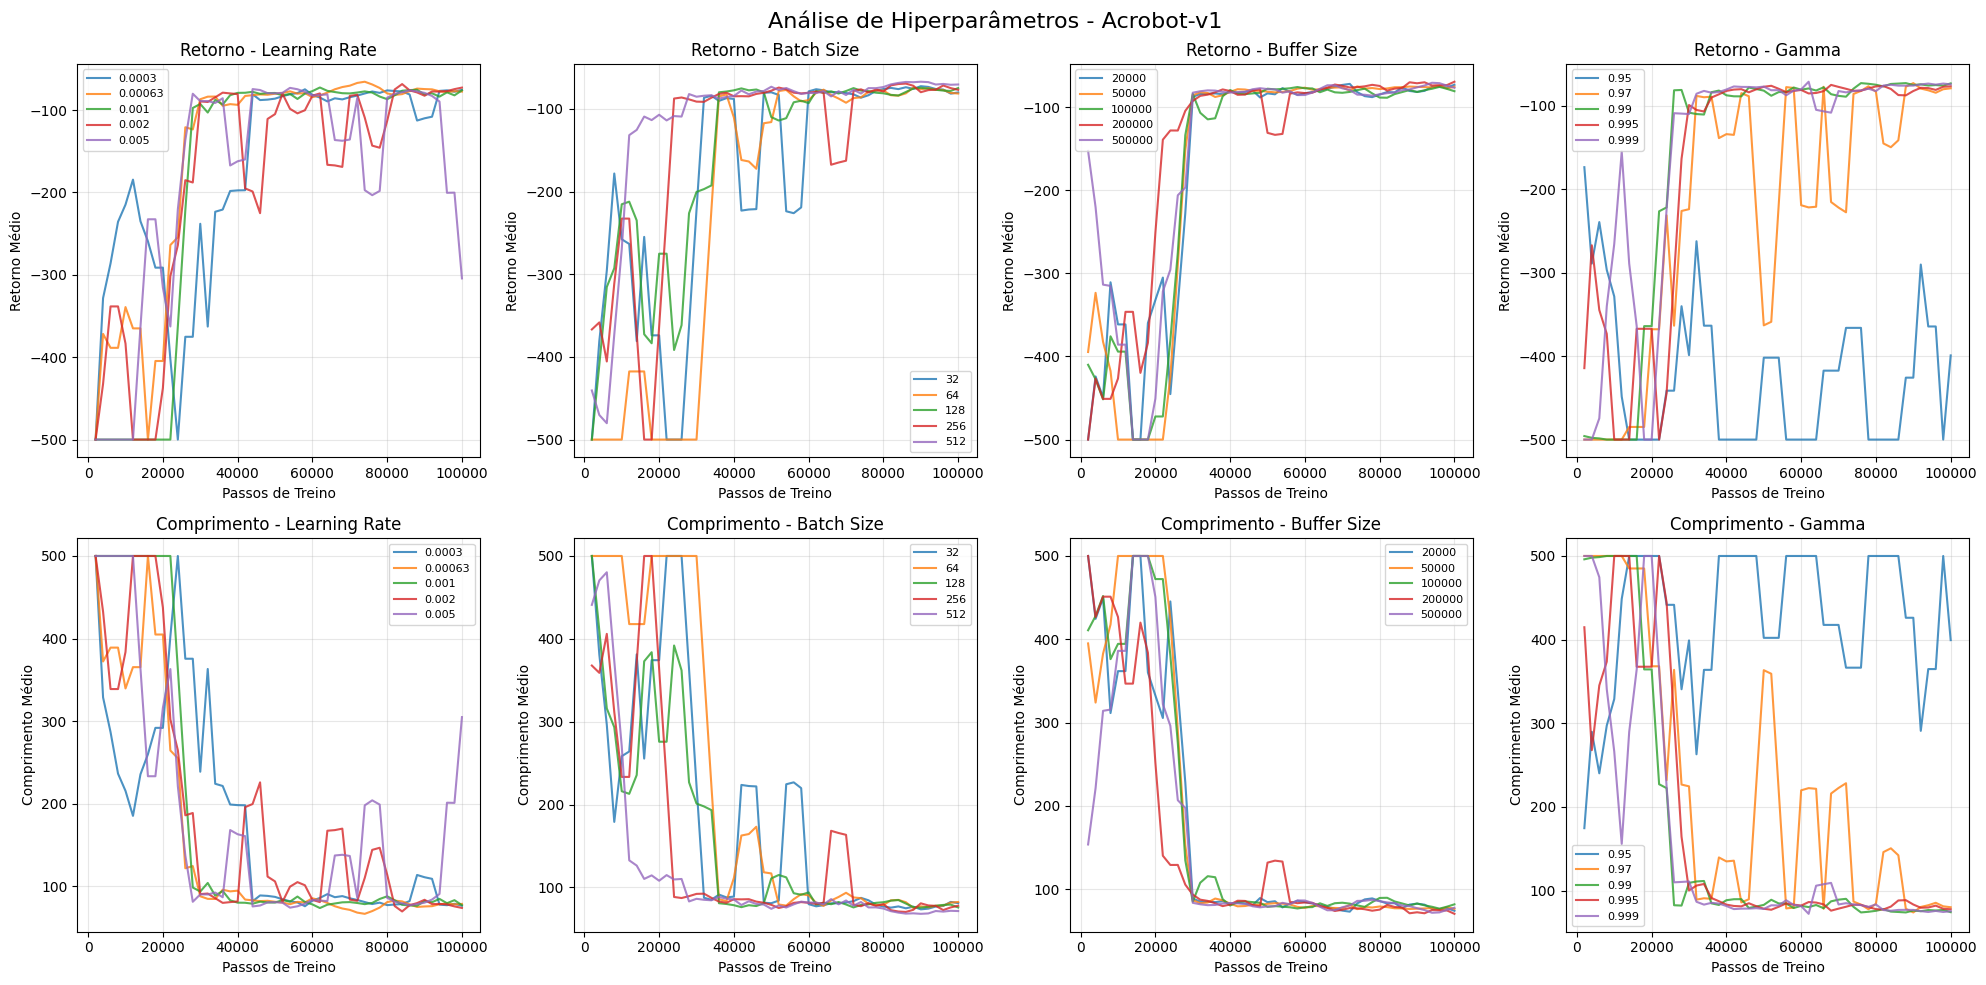


=== Tabela de Desempenho Final - Acrobot-v1 ===
    Parâmetro        Valor Retorno Final Comprimento Final
Learning Rate      0.00030        -73.20             74.20
Learning Rate      0.00063        -80.00             81.00
Learning Rate      0.00100        -65.60             66.60
Learning Rate      0.00200        -71.20             72.20
Learning Rate      0.00500       -416.00            416.20
   Batch Size     32.00000        -75.80             76.80
   Batch Size     64.00000        -80.80             81.80
   Batch Size    128.00000        -66.80             67.80
   Batch Size    256.00000        -76.60             77.60
   Batch Size    512.00000        -74.60             75.60
  Buffer Size  20000.00000        -69.00             70.00
  Buffer Size  50000.00000        -70.80             71.80
  Buffer Size 100000.00000        -79.20             80.20
  Buffer Size 200000.00000        -68.00             69.00
  Buffer Size 500000.00000        -78.00             79.00
       

In [30]:
# Organizar todos os resultados do Acrobot
acrobot_results = {
    'learning_rate': lr_results_acrobot,
    'batch_size': bs_results_acrobot,
    'buffer_size': buffer_results_acrobot,
    'gamma': gamma_results_acrobot
}

# Gráfico resumo para Acrobot
plot_all_hyperparameters_summary(acrobot_results, "Acrobot-v1")

# Tabela de desempenho
acrobot_table = create_performance_table(acrobot_results, "Acrobot-v1")

**Learning Rate**

- Taxas intermediárias (0.001 a 0.002) alcançaram bons resultados rapidamente, estabilizando o retorno em ~-100 e o comprimento em ~100 após 20k a 40k passos.

- Taxas muito baixas (0.0003) ou muito altas (0.005) foram menos estáveis, demorando mais ou até gerando oscilações.

**Batch Size**

- Tamanhos maiores (256 e 512) mostraram melhor estabilidade e rapidez para chegar em ~-100 e ~100, enquanto tamanhos muito pequenos (32) foram mais ruidosos.

**Buffer Size**

- Todos convergiram bem, mas buffers a partir de 50k ajudaram a estabilizar mais rápido. Buffers muito pequenos (20k) foram um pouco mais lentos.

**Gamma**

- Altos gammas (0.99 e 0.995) se destacaram por permitir atingir o retorno ótimo rapidamente (~20k passos), com episódios curtos (~100).
- Gammas menores (0.95) não chegaram a bons resultados.

### Conclusão Final

Os experimentos de sensibilidade a hiperparâmetros revelam importantes padrões sobre o comportamento do algoritmo DQN:

**1. Learning Rate:**
- Valores muito baixos podem resultar em aprendizado lento
- Valores muito altos podem causar instabilidade
- O valor ótimo varia significativamente entre ambientes

**2. Batch Size:**
- Lotes maiores geralmente oferecem gradientes mais estáveis
- Lotes muito pequenos podem aumentar a variância do treinamento
- O equilíbrio entre estabilidade e eficiência computacional é crucial

**3. Buffer Size:**
- Buffers maiores permitem maior diversidade de experiências
- Buffers muito pequenos podem levar a overfitting em experiências recentes
- O tamanho ótimo depende da complexidade do ambiente

**4. Gamma (Fator de Desconto):**
- Valores próximos a 1.0 favorecem recompensas de longo prazo
- Valores menores priorizam recompensas imediatas
- O valor ótimo está relacionado ao horizonte temporal do problema

**Observações Gerais:**
- Ambientes diferentes requerem configurações distintas de hiperparâmetros
- A estabilidade do treinamento varia significativamente entre configurações
- A importância relativa de cada hiperparâmetro depende das características específicas do ambiente